<a href="https://colab.research.google.com/github/keran-w/3d-deep-learning/blob/main/Notebooks/train-7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

from tqdm import tqdm
from google.colab import drive
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Setup

In [2]:
drive.mount('/content/drive', force_remount=True)

dataset_name = 'modelnet40'
%cd /content/drive/MyDrive/dataset/{dataset_name}
base_path = Path('.')
clear_output()

# Dataset

In [7]:
num_layer = 7
X_train, y_train_ = pickle.load(open(f'SavedData/train_dataset-{num_layer}.pkl','rb'))
# X_test, y_test_ = pickle.load(open(f'SavedData/test_dataset-{num_layer}.pkl','rb'))

In [4]:
X_train, X_valid, y_train_, y_valid_ = train_test_split(X_train, y_train_, test_size=0.15, random_state=20)
# stratify=y_train_, 

In [12]:
label_map = {
    0: 'airplane',
    1: 'bathtub',
    2: 'bed',
    3: 'bench',
    4: 'bookshelf',
    5: 'bottle',
    6: 'bowl',
    7: 'car',
    8: 'chair',
    9: 'cone',
    10: 'cup',
    11: 'curtain',
    12: 'desk',
    13: 'door',
    14: 'dresser',
    15: 'flower_pot',
    16: 'glass_box',
    17: 'guitar',
    18: 'keyboard',
    19: 'lamp',
    20: 'laptop',
    21: 'mantel',
    22: 'monitor',
    23: 'night_stand',
    24: 'person',
    25: 'piano',
    26: 'plant',
    27: 'radio',
    28: 'range_hood',
    29: 'sink',
    30: 'sofa',
    31: 'stairs',
    32: 'stool',
    33: 'table',
    34: 'tent',
    35: 'toilet',
    36: 'tv_stand',
    37: 'vase',
    38: 'wardrobe',
    39: 'xbox'
}

le = LabelEncoder()
le.fit(list(label_map.values()))
# y_train_ = le.transform(y_train)
# y_test_ = le.transform(y_test)
num_labels = len(label_map)

In [3]:
class bitmapDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return torch.tensor(self.X[index]).float(), self.y[index]

train_dataset = bitmapDataset(X_train, y_train_)
valid_dataset = bitmapDataset(X_valid, y_valid_)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [7]:
sample_batch = next(iter(train_loader))
sample_X, sample_y = sample_batch

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
class ArcFace(nn.Module):
    
    def __init__(self,in_features,out_features, margin = 0.5 ,scale = 20):
        super(ArcFace, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.weights = nn.Parameter(torch.FloatTensor(out_features,in_features))
        nn.init.xavier_normal_(self.weights)
        
    def forward(self,features,targets):
        cos_theta = F.linear(F.normalize(features), F.normalize(self.weights), bias=None) 
        cos_theta = cos_theta.clip(-1, 1)
        
        arc_cos = torch.acos(cos_theta)
        M = F.one_hot(targets, num_classes = self.out_features) * self.margin
        arc_cos = arc_cos + M
        
        cos_theta_2 = torch.cos(arc_cos)
        logits = cos_theta_2 * self.scale
        return logits

class FocalLoss(nn.Module):
    'Focal Loss - https://arxiv.org/abs/1708.02002'
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

class MVNet(nn.Module):
    def __init__(self, num_labels):
        super(MVNet, self).__init__()
        self.conv1 = nn.LazyConv2d(out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.LazyConv2d(out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.LazyLinear(768)
        self.arcface = ArcFace(768, num_labels, margin=0.3)

    def forward(self, x, y=None, mode='train'):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        if mode == 'train':
            return self.arcface(x, y)
        else:
            return F.linear(F.normalize(x), F.normalize(self.arcface.weights))
 

# sample_model = MVNet(num_labels).to(device)
# sample_output = sample_model(sample_X.float().to(device), sample_y.long().to(device))
# sample_criterion = FocalLoss(2)
# sample_optimizer = optimizer = torch.optim.Adam(sample_model.parameters(), lr=1e-3)
# sample_loss = sample_criterion(sample_output, sample_y.to(device))
# sample_loss

# Train

In [11]:
model = MVNet(num_labels).to(device)
criterion = FocalLoss(2)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

n_epoch = 15

all_loss_list = []
all_acc_list = []

for epoch in range(n_epoch):
    model.train()
    train_pbar = tqdm(train_loader)
    train_pbar.set_description_str(f'[ Train {epoch+1:03d}/{n_epoch:03d} ]')
    loss_list, acc_list = [], []
    for batch in train_pbar:
        X, y = batch
        # loss = train_step(model, optimizer, criterion, batch, device)
        optimizer.zero_grad()
        logits = model(X.float().to(device), y.long().to(device))
        true_labels = y.long().to(device)
        loss = criterion(logits, true_labels)
        loss.backward()
        optimizer.step()
        train_pbar.set_postfix_str(f'loss: {loss}')
        loss_list.append(loss.item())
        
    model.eval()
    with torch.no_grad():
        valid_pbar = tqdm(valid_loader)
        valid_pbar.set_description_str(f'[ Valid {epoch+1:03d}/{n_epoch:03d} ]')
        for batch in valid_pbar:
            X, y = batch
            logits = model(X.float().to(device), mode='valid').detach()
            true_labels = y.long().to(device)

            results = {}
            metric = 'acc'
            results[metric] = (logits.argmax(1) == true_labels).float().mean().item()
            valid_pbar.set_postfix_str(f'{" ".join([f"{k}: {v}" for k, v in results.items()])}')
            acc_list.append(results['acc'])

    print(f'Average train loss: {np.mean(loss_list):.4f} Average validation accuracy: {np.mean(acc_list):.3f}')
    all_loss_list.append(np.mean(loss_list))
    all_acc_list.append(np.mean(acc_list))


[ Valid 001/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.85it/s, acc: 1.0]


Average train loss: 7.2122 Average validation accuracy: 0.643


[ Valid 002/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.87it/s, acc: 1.0]


Average train loss: 4.1620 Average validation accuracy: 0.717


[ Valid 003/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.89it/s, acc: 1.0]


Average train loss: 2.3598 Average validation accuracy: 0.732


[ Valid 004/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.88it/s, acc: 1.0]


Average train loss: 1.1431 Average validation accuracy: 0.742


[ Valid 005/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.82it/s, acc: 1.0]


Average train loss: 0.5030 Average validation accuracy: 0.747


[ Valid 006/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.88it/s, acc: 1.0]


Average train loss: 0.2430 Average validation accuracy: 0.743


[ Valid 007/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.85it/s, acc: 1.0]


Average train loss: 0.1435 Average validation accuracy: 0.749


[ Valid 008/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.92it/s, acc: 1.0]


Average train loss: 0.0938 Average validation accuracy: 0.750


[ Valid 009/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.87it/s, acc: 1.0]


Average train loss: 0.0652 Average validation accuracy: 0.749


[ Valid 010/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.86it/s, acc: 1.0]


Average train loss: 0.0524 Average validation accuracy: 0.750


[ Valid 011/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.90it/s, acc: 1.0]


Average train loss: 0.0454 Average validation accuracy: 0.749


[ Valid 012/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.92it/s, acc: 1.0]


Average train loss: 0.0357 Average validation accuracy: 0.750


[ Valid 013/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.89it/s, acc: 1.0]


Average train loss: 0.0333 Average validation accuracy: 0.749


[ Valid 014/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.90it/s, acc: 1.0]


Average train loss: 0.0314 Average validation accuracy: 0.753


[ Valid 015/015 ]: 100%|██████████| 24/24 [00:08<00:00,  2.92it/s, acc: 1.0]

Average train loss: 0.0241 Average validation accuracy: 0.753


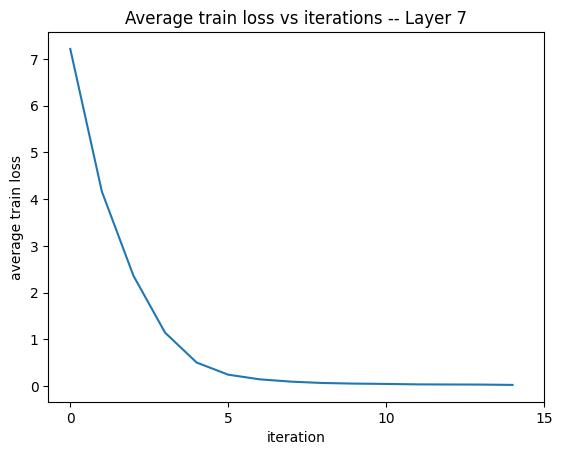

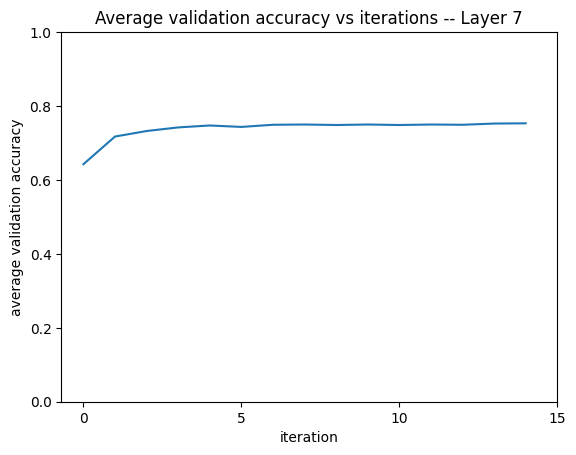

In [12]:
# all_loss_list, all_acc_list
sns.lineplot(all_loss_list)
plt.xlabel('iteration')
plt.ylabel('average train loss')
plt.title(f'Average train loss vs iterations -- Layer {num_layer}')
plt.xticks(list(range(0,len(all_loss_list)+1,5)))
plt.show()

sns.lineplot(all_acc_list)
plt.xlabel('iteration')
plt.ylabel('average validation accuracy')
plt.title(f'Average validation accuracy vs iterations -- Layer {num_layer}')
plt.xticks(list(range(0,len(all_acc_list)+1,5)))
plt.ylim([0,1])
plt.show()


In [ ]:
# !mkdir SavedPretrainedModel

In [13]:
# model_path = base_path/f'SavedPretrainedModel/model-{num_layer}.pt'
# torch.save(model, base_path/f'SavedPretrainedModel/model-{num_layer}.pt')

In [8]:
# X_train, y_train = pickle.load(open(f'SavedData/train_dataset-{num_layer}.pkl','rb'))
X_test, y_test = pickle.load(open(f'SavedData/test_dataset-{num_layer}.pkl','rb'))

In [9]:
le = LabelEncoder()
le.fit(y_test)
y_test_ = le.transform(y_test)
test_dataset = bitmapDataset(X_test, y_test_)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model_path = base_path/f'SavedPretrainedModel/model-{num_layer}.pt'
model = torch.load(model_path).to(device)
model.eval()
pred_labels = []
true_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        X, y = batch
        logits = model(X.float().to(device), y=None, mode='test').detach()
        pred_labels += logits.argmax(1).tolist()
        true_labels += y.long().tolist()

np.mean([int(i == j) for i,j in zip(true_labels, pred_labels)])

100%|██████████| 39/39 [00:21<00:00,  1.78it/s]


0.7352821762078766

In [10]:
from sklearn import metrics
metrics.accuracy_score(true_labels, pred_labels)

0.7352821762078766

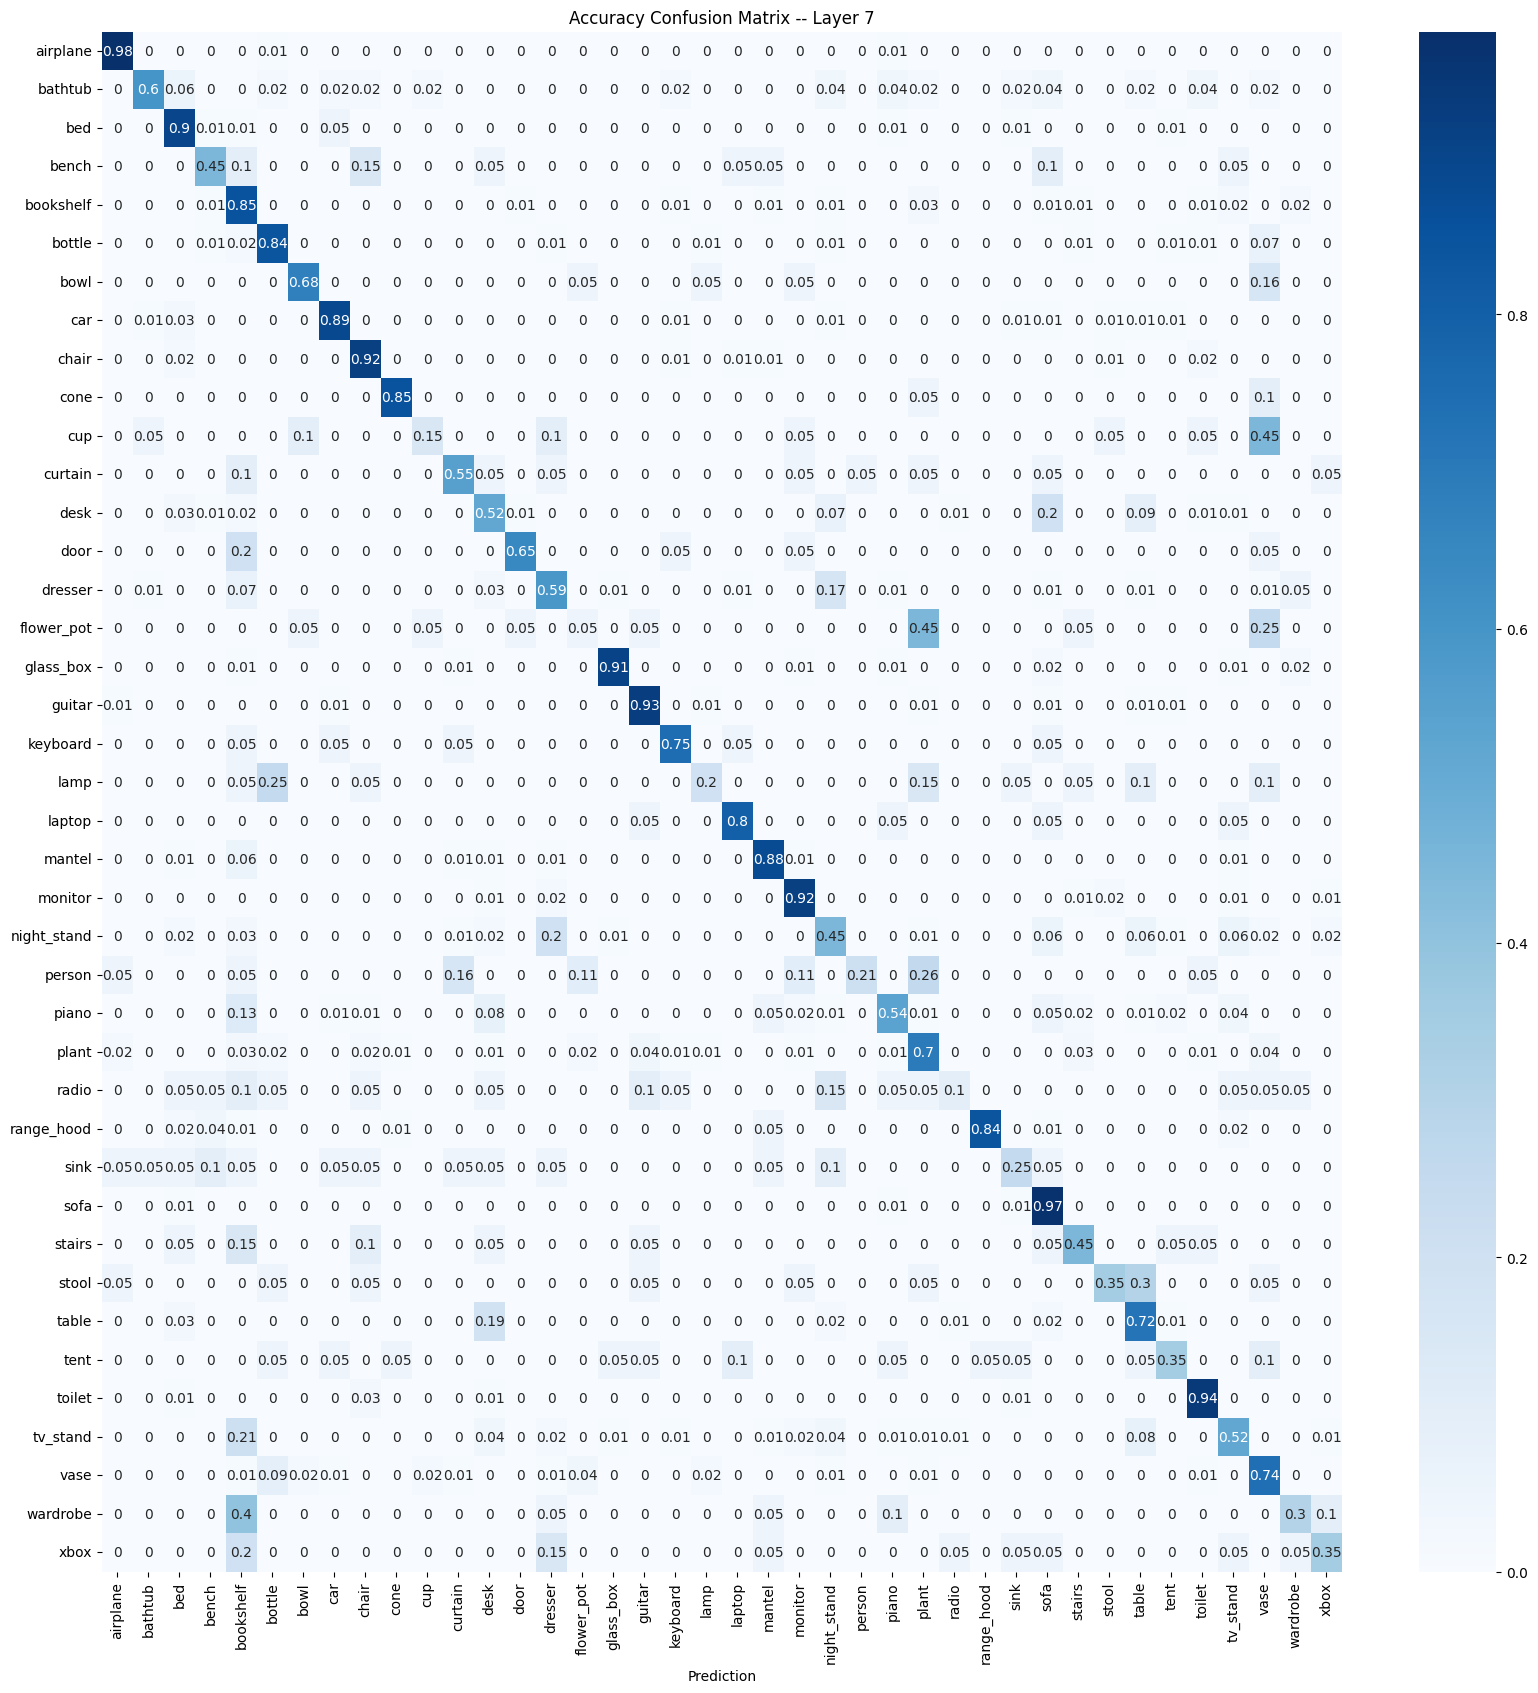

In [13]:
import seaborn as sns
from sklearn import metrics
cf_matrix = metrics.confusion_matrix(true_labels, pred_labels)
cf_matrix = pd.DataFrame(cf_matrix, columns=list(label_map.values()), index=list(label_map.values()))
cf_matrix = np.round(cf_matrix / cf_matrix.sum(1).values.repeat(num_labels).reshape(num_labels, num_labels), 2)
plt.figure(figsize=(20,20))
sns.heatmap(cf_matrix, annot=True, cmap="Blues")
plt.title(f'Accuracy Confusion Matrix -- Layer {num_layer}')
plt.xlabel('True label')
plt.xlabel('Prediction')
plt.show()